# Practical Work 4 - Autoencoder
# Question 2 : Denoising autoencoder

## Introduction

Main goal: build an denoising autoencoder using Keras
- Introduce noise in the input;
- the output is the denoised image;
- Use Sequential mode.

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [82]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras as tk
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

## MNIST dataset loading
The MNIST data is loaded. The parameters of the database are retrieved (number of examples, of classes, size of the retina)

Remark : The MNIST (Mixed National Institute of Standards and Technology) database is a database of handwritten numbers. It is a standard database for testing new algorithms for recognizing these digits. It consists of 60000 training images and 10000 test images. Grayscale images are normalized and centered with the size of 28 pixels and 28 pixels.


The MNIST data is then loaded. The parameters of the database are retrieved (number of examples, of classes, size of the retina).
The training dataset is processed by added a noise.

Size of the retina :  784
Number of samples  :  60000


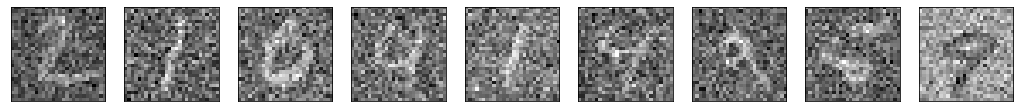

In [83]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Number of samples in the training dataset
num_examples = x_train.shape[0] 
# Number of samples in the test dataset
num_test = x_test.shape[0]
# Size of the input layer (retina) = number of pixels of the MNIST images (784 pixels)
num_input = x_train.shape[1]*x_train.shape[2]
# Number of classes ( the 10 digits : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})
num_classes = 10

# Size 
img_size = x_train.shape[1] 
img_shape = (img_size, img_size)

# Reshape of datatsets in array and normalization
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), img_size, img_size, 1))
x_test = np.reshape(x_test, (len(x_test), img_size, img_size, 1))

# Print
print('Size of the retina : ',num_input)
print("Number of samples  : ",num_examples)

# Add noise on training dataset
# TODO : generate the training dataset (mnist dataset with noise)
noise = 0.5
x_train_noised = x_train + noise * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noised  = x_test  + noise * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
  

# Print the training dataset
plt.figure(figsize=(20, 2))
for i in range(1,10):
    ax = plt.subplot(1, 10, i)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(x_test_noised[i].reshape(img_size, img_size), cmap="binary")
plt.show()

#model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_size,img_size,1)))

## Model (CNN-based Autoencoder)
### Global parameters 

In [84]:
# Algorithm parameters
lr = 0.001
num_epochs = 5
batch_size = 256

### Definition of the autoencoder model
** CONV - MAX POOLING - CONV - MAX POOLING - CONV - UPSAMPLING - CONV - UPSAMPLING - CONV **

In [85]:
# TODO : Build the CNN based autoencoder 
inputs = Input(shape=(img_size,img_size,1))
x = Conv2D(32, (3,3), activation="relu", padding='same')(inputs)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(64, (3,3), activation="relu", padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(64, (3,3), activation="relu", padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation="relu", padding='same')(x)
x = UpSampling2D((2,2))(x)

x = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

### Model construction (loss function & optimization prodedure)
- Loss function : try [mean square error](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MSE) and [binary cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) (even it is quite strange from a reconstruction perspective)
- Optimization procedure : gradient descent by [Adam](https://keras.io/api/optimizers/adam/) - see [publication](https://arxiv.org/abs/1412.6980).

Use accuracy metrics to monitor the learning phase.

In [86]:
#TODO
model = Model(inputs=inputs, outputs=x)
model.summary()

adam = Adam(lr=lr)
model.compile(loss="mse", optimizer=adam)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 14, 14, 64)        0   

### Learning and test
We implement a [custom allback function](https://keras.io/api/callbacks/) to display intermediate images during the training phase.

In [87]:
class myCallback(tk.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        encoder = K.function([model.layers[0].input],[model.layers[3].output])
        if((epoch-1) % 2==0):   
            print("\nEpoch {0:d} Accuracy :{1:5.3f} ".format(epoch-1,logs.get('acc') ))
            decoded_imgs = model.predict(x_test)
            encoded_imgs = encoder([x_test_noised])[0]

            n = 8  
            plt.figure(figsize=(40, 4))
            for i in range(n):
                ax = plt.subplot(3, 20, i + 1)
                plt.imshow(x_test_noised[i].reshape(img_size, img_size))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                ax = plt.subplot(3, 20, i + 1 + 20)
                plt.imshow(encoded_imgs[i].reshape(64,49))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                ax = plt.subplot(3, 20, 2*20 +i+ 1)
                plt.imshow(decoded_imgs[i].reshape(img_size, img_size))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

            plt.show()

            
callbacks = myCallback()
model.fit(x_train_noised,x_train,epochs=num_epochs,batch_size=batch_size,validation_data=(x_test_noised, x_test),callbacks=[callbacks])
model.save('denoising_autoencoder.model')


Epoch 1/5
235/235 [==============================] - 190s 806ms/step - loss: 0.1171 - val_loss: 0.1140
Epoch 2/5
235/235 [==============================] - 189s 805ms/step - loss: 0.1120 - val_loss: 0.1140


TypeError: ignored

### Test : prediction
 - evaluate : [Returns the loss value & metrics values for the model in test mode](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate).

In [ ]:
model.evaluate(x_test_noised, x_test)


### Test : print the denoised images
 - predict : [Generates output predictions for the input samples](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict).

In [ ]:
denoised_img = model.predict(x_test_noised)
plt.figure(figsize=(40, 4))
for i in range(10):
    ax = plt.subplot(3, 20, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(x_test_noised[i].reshape(img_size, img_size))
    
    ax = plt.subplot(3, 20, 40 +i+ 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(denoised_img[i].reshape(img_size, img_size))

plt.tight_layout()